#### A quick demonstration of bias-hardened lensing/patchy tau/point source reconstruction in fullsky
#### - this code shows how to compute the estiamtors, and output their power spectra

In [1]:
import numpy as np, basic, curvedsky as cs, plottools as pl, pickle, quad_func, tqdm, misctools, cmb
from matplotlib.pyplot import *

In [2]:
# define parameters
Tcmb  = 2.726e6    # CMB temperature
lmax  = 2048       # maximum multipole of output normalization
rlmin, rlmax = 100, lmax  # reconstruction multipole range
sig   = 50.
ac2rad = np.pi/180./60.
L = np.linspace(0,lmax,lmax+1)
simn = 10
root = '/global/homes/t/toshiyan/scratch/test/'

#### load unlensed and lensed Cls

In [3]:
lcl = cmb.read_camb_cls('../data/lensedcls.dat',ftype='lens',output='array')[:,:lmax+1]
nl  = np.zeros((4,lmax+1))
nl[0,:] = (sig*ac2rad/Tcmb)**2
nl[1,:] = 2*nl[0,:]
nl[2,:] = 2*nl[0,:]
ocl = lcl + nl

#### Calculate normalizations, N0 and RDN0

In [4]:
# example setup of filename and its ids
ids = [str(i).zfill(5) for i in range(-1,1000)]
ids[0] = 'real'  # change 1st index
falm = { m: [root+'test_'+m+'_'+x+'.pkl' for x in ids] for m in ['T','E','B'] }

In [5]:
# generate CMB alms 
for i in tqdm.tqdm(range(simn+1)):
    if misctools.check_path(falm['T'][i]): continue
    Talm = cs.utils.gauss1alm(lmax,lcl[0,:])
    Talm += cs.utils.gauss1alm(lmax,nl[0,:])
    pickle.dump((Talm),open(falm['T'][i],"wb"),protocol=pickle.HIGHEST_PROTOCOL)

100%|██████████| 11/11 [00:03<00:00,  3.26it/s]


In [6]:
qobj = quad_func.quad(root=root,rlz=range(simn+1),qtype='tau',bhe=['lens'],\
                      lcl=lcl,ocl=ocl,ifl=ocl,falm=falm,rlmin=rlmin,rlmax=rlmax,\
                      n0max=np.int(simn/2),rdmax=simn,nside=1024,qlist=['TT'],ids=ids,overwrite=True
                     )

/global/homes/t/toshiyan/.conda/envs/loc/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
qobj.qrec_flow(run=['norm'])
#qobj.qrec_flow(run=['rdn0'])

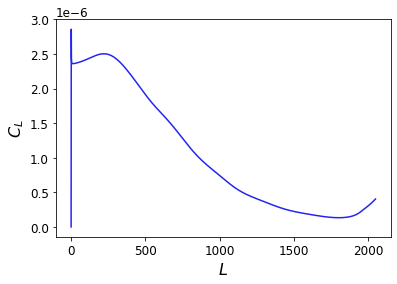

In [8]:
pl.plot_1dstyle()
l, al = np.loadtxt(qobj.f['TT'].al,unpack=True,usecols=(0,1))
plot(l,al)